# TRMF--LSTM

## 数据预处理

### 导入数据，科学计算函数包，以及基本工作

先导入我们的trmf代码块和科学计算包

In [2]:
import numpy as np
import pandas as pd
from trmf import trmf
from RollingCV import RollingCV
import matplotlib.pyplot as plt
%matplotlib inline 
#上面这个是jupyter独有的，意思是设置matplotlib为作图后端
plt.rc("font",family='YouYuan')#设置绘图中文“幼圆字体”读取，因为原来读不了中文

然后导入数据，这里我们把日期变为时间索引，顺便查看一下

然后对我们感兴趣的变量“收盘价”绘制时序图

In [3]:
df = pd.read_csv('TSLA.csv',parse_dates = ['Date'] , index_col = 'Date')
df

,Close,Open,High,Low,Volume
Date,,,,,
2022-04-01,361.53,360.38,364.92,355.55,54263100.0
2022-04-04,381.82,363.13,383.30,357.51,82035900.0
2022-04-05,363.75,378.77,384.29,362.43,80075100.0
2022-04-06,348.59,357.82,359.67,342.57,89348400.0
2022-04-07,352.42,350.80,358.86,340.51,79447200.0
...,...,...,...,...,...
2023-03-27,191.81,194.42,197.39,189.94,120851600.0
2023-03-28,189.19,192.00,192.35,185.43,98654600.0
2023-03-29,193.88,193.13,195.29,189.44,123660000.0


In [4]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-04-01 to 2023-03-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   251 non-null    float64
 1   Open    251 non-null    float64
 2   High    251 non-null    float64
 3   Low     251 non-null    float64
 4   Volume  251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


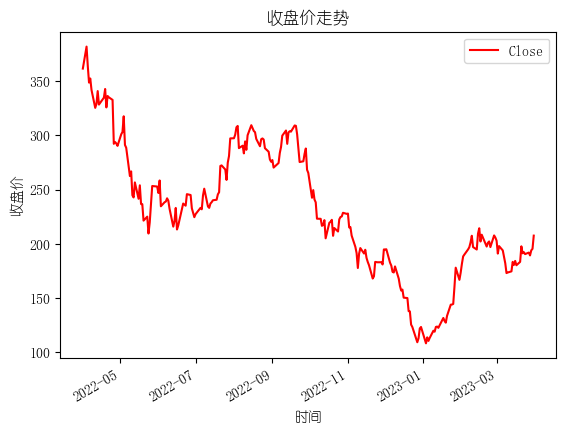

In [5]:
plt.rc("font",family='YouYuan')#设置中文“幼圆字体”读取，因为原来读不了中文
df.plot(y='Close',color='r')
plt.title('收盘价走势')  #图形名称
plt.xlabel('时间')        #X轴标签
plt.ylabel('收盘价')      #Y轴标签
plt.show()                #绘图

这里我要提取“close”列，并将其作为一个新的数据框，最后对比用

In [6]:
df_final =  pd.DataFrame(df, columns=['Close'])

In [7]:
df_final = df_final.rename(columns={'Close': 'Y'})

In [8]:
df_final

,Y
Date,
2022-04-01,361.53
2022-04-04,381.82
2022-04-05,363.75
2022-04-06,348.59
2022-04-07,352.42
...,...
2023-03-27,191.81
2023-03-28,189.19
2023-03-29,193.88


### 特征工程——数据归一化

因为量纲不一样，所以要先消除量纲影响。这里选择最小最大标准化，即y = (x - min) / (max - min)

In [9]:
# 导入模块
from sklearn.preprocessing import MinMaxScaler
# 创建归一化对象
scaler = MinMaxScaler()

In [10]:
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns , index=df.index)

In [11]:
df_normalized

,Close,Open,High,Low,Volume
Date,,,,,
2022-04-01,0.925873,0.933314,0.928928,0.973601,0.046835
2022-04-04,1.000000,0.943286,0.996368,0.981122,0.151746
2022-04-05,0.933984,1.000000,1.000000,1.000000,0.144339
2022-04-06,0.878599,0.924031,0.909665,0.923797,0.179369
2022-04-07,0.892591,0.898575,0.906693,0.915893,0.141968
...,...,...,...,...,...
2023-03-27,0.305823,0.331508,0.314229,0.338155,0.298372
2023-03-28,0.296252,0.322733,0.295736,0.320850,0.214523
2023-03-29,0.313386,0.326830,0.306524,0.336237,0.308981


### 特征工程——划分数据集为训练集和测试集

时间序列数据是有序的，也就是说，每个观测值都与之前的观测值有关。因此，不能像普通的交叉验证方法那样随机地将数据分成训练集和测试集，否则会破坏时间序列的结构和依赖性。TimeSeriesSplit是一种专门针对时间序列数据的交叉验证方法，它可以保证每次分割时，测试集的索引都比训练集的索引高，也就是说，测试集总是在训练集之后。这样可以模拟真实的时间序列预测场景，即用过去的数据来预测未来的数据。

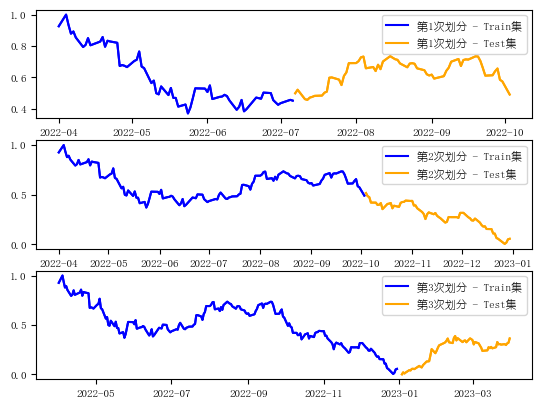

In [12]:
# 导入sklearn库中的TimeSeriesSplit类
from sklearn.model_selection import TimeSeriesSplit
# 导入matplotlib库中的pyplot模块，并起别名plt
import matplotlib.pyplot as plt


# 创建一个空列表，用来存储每次划分后的数据
data_splits = []


# 创建一个TimeSeriesSplit对象，指定n_splits参数为3，表示3次交叉验证
time_series_splitter = TimeSeriesSplit(n_splits=3)

# 创建一个变量i，用来记录当前是第几次划分
i = 1

# 使用time_series_splitter.split方法对数据框normalized_df进行分割，并返回一个迭代器
for train_index, test_index in time_series_splitter.split(df_normalized):
    # 根据训练索引和测试索引提取出训练集和测试集中的所有特征列，并赋值给train_features和test_features变量
    train_features = df_normalized.loc[df_normalized.index[train_index]]
    test_features = df_normalized.loc[df_normalized.index[test_index]]
    
    # 根据训练索引和测试索引提取出训练集和测试集中的目标列，并赋值给train_target和test_target变量
    train_target = df_normalized['Close'].loc[df_normalized.index[train_index]]
    test_target = df_normalized['Close'].loc[df_normalized.index[test_index]]
    
    
    # 设置图形的字体大小为8
    plt.rcParams['font.size'] = 8
    
    # 使用plt.subplot方法创建一个子图，指定行数为3，列数为1，当前位置为i
    plt.subplot(3, 1, i)
    
    # 使用plt.plot方法绘制训练集和测试集的目标值，分别用蓝色和橙色表示
    plt.plot(train_target, color='blue')
    plt.plot(test_target, color='orange')
    
    # 使用plt.plot方法绘制训练集和测试集的目标值，分别用蓝色和橙色表示，并添加图例注记
    plt.plot(train_target, color='blue', label=f'第{i}次划分 - Train集')
    plt.plot(test_target, color='orange', label=f'第{i}次划分 - Test集')
    
    # 使用plt.legend方法显示图例注记，并指定位置为最佳位置
    plt.legend(loc='best')
    
    # 将i的值加1，为下一次循环做准备
    i += 1
    
# 使用plt.show方法显示图形
plt.show()

for train_index, test_index in time_series_splitter.split(df_normalized):
    #打印出每次循环得到的训练索引和测试索引
    print("TRAIN:", train_index, "TEST:", test_index)
    # 打印出每次循环得到的训练索引和测试索引的值
    print("TRAIN:", df_normalized.index.values[train_index], "TEST:", df_normalized.index.values[test_index])

我不想一直重复划分，所以基于刚才的划分结果直接训练，将划分后的数据保存到一个列表或字典中，然后在训练时直接从列表或字典中取出相应的数据。也就是说在每次循环中将训练集和测试集的特征和目标值添加到一个字典中，然后将字典添加到一个列表中

In [13]:
# 创建一个空列表，用来存储每次划分后的数据
data_splits = []

# 使用time_series_splitter.split方法对数据框normalized_df进行分割，并返回一个迭代器
for train_index, test_index in time_series_splitter.split(df_normalized):
    # 根据训练索引和测试索引提取出训练集和测试集中的所有特征列，并赋值给train_features和test_features变量
    train_features = df_normalized.loc[df_normalized.index[train_index]]
    test_features = df_normalized.loc[df_normalized.index[test_index]]
    
    # 根据训练索引和测试索引提取出训练集和测试集中的目标列，并赋值给train_target和test_target变量
    train_target = df_normalized['Close'].loc[df_normalized.index[train_index]]
    test_target = df_normalized['Close'].loc[df_normalized.index[test_index]]
    
    # 创建一个字典，用来存储当前划分后的数据
    data_split = {
        'train_features': train_features,
        'test_features': test_features,
        'train_target': train_target,
        'test_target': test_target
    }
    
    # 将字典添加到列表中
    data_splits.append(data_split)

在训练时，你可以直接从列表中取出相应的数据

## 针对训练集进行TRMF处理

#### 定义TRMF函数

In [14]:
# 导入numpy库，用于矩阵运算
import numpy as np
# 导入numpy.linalg库中的inv函数，用于求矩阵的逆
from numpy.linalg import inv as inv

# 定义TRMF函数，输入参数为dense_mat（原始矩阵），sparse_mat（稀疏矩阵），init_para（初始化参数），init_hyper（初始化超参数），time_lags（时间滞后项），maxiter（最大迭代次数）
def TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter):
    """Temporal Regularized Matrix Factorization, TRMF."""
    # 初始化空间矩阵W，时间矩阵X，自回归系数矩阵theta
    W = init_para["W"]
    X = init_para["X"]
    theta = init_para["theta"]
    # 设置超参数lambda_w（空间矩阵的正则化系数），lambda_x（时间矩阵的正则化系数），lambda_theta（自回归系数的正则化系数），eta（时间平滑系数）
    lambda_w = init_hyper["lambda_w"]
    lambda_x = init_hyper["lambda_x"]
    lambda_theta = init_hyper["lambda_theta"]
    eta = init_hyper["eta"]
    # 获取稀疏矩阵的维度
    dim1, dim2 = sparse_mat.shape
    # 获取稀疏矩阵中非零元素的位置
    pos_train = np.where(sparse_mat != 0)
    # 获取原始矩阵中非零且稀疏矩阵中为零的元素的位置，用于测试集
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    # 复制稀疏矩阵，并将非零元素置为1，用于计算二值权重
    binary_mat = sparse_mat.copy()
    binary_mat[pos_train] = 1
    # 获取自回归系数矩阵的维度
    d, rank = theta.shape
    # 迭代更新参数
    for it in range(maxiter):
        # 更新空间矩阵W
        for i in range(dim1):
            # 获取第i行稀疏矩阵中非零元素的位置
            pos0 = np.where(sparse_mat[i, :] != 0)
            # 获取对应位置的时间矩阵X的转置
            Xt = X[pos0[0], :]
            # 计算第i行稀疏矩阵与时间矩阵X转置的乘积
            vec0 = Xt.T @ sparse_mat[i, pos0[0]]
            # 计算时间矩阵X转置与自身乘积加上空间正则化项的逆
            mat0 = inv(Xt.T @ Xt + lambda_w * np.eye(rank))
            # 更新第i行空间矩阵W为上述两个向量的乘积
            W[i, :] = mat0 @ vec0
        
        # 更新时间矩阵X
        for t in range(dim2):
            # 获取第t列稀疏矩阵中非零元素的位置
            pos0 = np.where(sparse_mat[:, t] != 0)
            # 获取对应位置的空间矩阵W
            Wt = W[pos0[0], :]
            # 初始化Mt和Nt为零向量，用于计算自回归项和交叉项
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            # 如果t小于最大滞后项，则Pt为零向量，Qt为零向量，否则Pt为单位向量，Qt为自回归系#数矩阵theta与时间矩阵X滞后项的乘积
            if t < np.max(time_lags):
                Pt = np.zeros((rank, rank))
                Qt = np.zeros(rank)
            else:
                Pt = np.eye(rank)
                Qt = np.einsum('ij, ij -> j', theta, X[t - time_lags, :])
            # 如果t小于最小滞后项的倒数，则计算Mt和Nt时需要考虑边界条件，否则不需要
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    # 如果t在最大滞后项和最小滞后项的倒数之间，则计算Mt和Nt时需要考虑所有的滞后项
                    index = list(range(0, d))
                else:
                    # 如果t在最大滞后项之前或最小滞后项的倒数之后，则计算Mt和Nt时只需要考虑部分滞后项
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2))[0])
                for k in index:
                    # 获取第k行自回归系数矩阵theta
                    Ak = theta[k, :]
                    # 计算Mt为所有滞后项的平方和
                    Mt += np.diag(Ak ** 2)
                    # 复制自回归系数矩阵theta，并将第k行置为零
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    # 计算Nt为所有滞后项与交叉项的乘积和
                    Nt += np.multiply(Ak, X[t + time_lags[k], :] - np.einsum('ij, ij -> j', theta0, X[t + time_lags[k] - time_lags, :]))
            # 计算第t列稀疏矩阵与空间矩阵W的乘积，加上时间正则化项，自回归项和交叉项
            vec0 = Wt.T @ sparse_mat[pos0[0], t] + lambda_x * Nt + lambda_x * Qt
            # 计算空间矩阵W与自身乘积，加上时间正则化项，自回归项和时间平滑项的逆
            mat0 = inv(Wt.T @ Wt + lambda_x * Mt + lambda_x * Pt + lambda_x * eta * np.eye(rank))
            # 更新第t列时间矩阵X为上述两个向量的乘积
            X[t, :] = mat0 @ vec0
        
        # 更新自回归系数矩阵theta
        for k in range(d):
            # 复制自回归系数矩阵theta，并将第k行置为零
            theta0 = theta.copy()
            theta0[k, :] = 0
            # 初始化mat0为零矩阵，用于计算自回归误差
            mat0 = np.zeros((dim2 - np.max(time_lags), rank))
            for L in range(d):
                # 计算mat0为所有滞后项与自回归系数的乘积和
                mat0 += X[np.max(time_lags) - time_lags[L] : dim2 - time_lags[L] , :] @ np.diag(theta0[L, :])
            # 计算VarPi为时间矩阵X减去mat0，即自回归误差
            VarPi = X[np.max(time_lags) : dim2, :] - mat0
            # 初始化var1和var2为零向量，用于计算自回归系数的更新公式中的分子和分母
            var1 = np.zeros((rank, rank ))
            var2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim2):
                # 获取第t列时间矩阵X的第k个滞后项
                B = X[t - time_lags[k], :]
                # 计算var1为所有滞后项的平方和
                var1 += np.diag(np.multiply(B, B))
                # 计算var2为所有滞后项与自回归误差的乘积和
                var2 += np.diag(B) @ VarPi[t - np.max(time_lags), :]
            # 更新第k行自回归系数矩阵theta为var1加上自回归正则化项的逆乘以var2
            theta[k, :] = inv(var1 + lambda_theta * np.eye(rank) / lambda_x) @ var2
        
        # 计算空间矩阵W与时间矩阵X的乘积，得到填补后的矩阵mat_hat
        mat_hat = W @ X.T
        # 计算测试集上的平均绝对百分比误差（MAPE）
        mape = np.sum(np.abs(dense_mat[pos_test] - mat_hat[pos_test]) / dense_mat[pos_test]) / dense_mat[pos_test].shape[0]
        # 计算测试集上的均方根误差（RMSE）
        rmse = np.sqrt(np.sum((dense_mat[pos_test] - mat_hat[pos_test]) ** 2)/dense_mat[pos_test].shape[0])
        # 每隔100次迭代，打印一次误差指标
        if (it + 1) % 100 == 0:
            print('Iter: {}'.format(it + 1))
            print('Imputation MAPE: {:.6}'.format(mape))
            print('Imputation RMSE: {:.6}'.format(rmse))
            print()
    # 返回填补后的矩阵mat_hat
    return mat_hat

#### 定义ar4cast函数: 这个函数是用来根据 theta 和 X 来预测未来几步的 X 的值，它就是用 theta 和 X 中的滞后期的数据来计算每一步的预测值。

In [32]:
def ar4cast(theta, X, time_lags, multi_step):
    """这个函数根据 theta 和 X 中的滞后期的数据来预测未来几步的 X 的值。
    
    参数
    ----------
    theta: numpy 数组
        自回归系数矩阵，形状为 (d, rank)，其中 d 是滞后期的个数，rank 是隐变量的维度。
    X: numpy 数组
        时间矩阵，形状为 (dim2, rank)，其中 dim2 是时间点的个数，rank 是隐变量的维度。
    time_lags: numpy 数组
        滞后期向量，形状为 (d,)，其中 d 是滞后期的个数。
    multi_step: 整数
        预测步数。

    返回
    -------
    X_new: numpy 数组
        新的时间矩阵，形状为 (dim2 + multi_step, rank)，其中 dim2 是时间点的个数，rank 是隐变量的维度。它包含了原始的 X 和预测的值。
    """
    
    dim2, rank = X.shape # 获取 X 的形状
    d = time_lags.shape[0] # 获取滞后期的个数
    X_new = np.append(X, np.zeros((multi_step, rank)), axis = 0) # 初始化一个新的矩阵，用零来填充预测值
    for t in range(multi_step): # 循环预测步数
        X_new[dim2 + t, :] = np.einsum('kr, kr -> r', theta, X_new[dim2 + t - time_lags, :]) # 根据 theta 和 X 中的滞后期的数据来计算每一步的预测值
    return X_new # 返回新的矩阵


#### 定义compute_mape: 这个函数是用来计算平均绝对百分比误差（MAPE）的，它是一种评估预测准确性的指标，它是真实值和预测值之差的绝对值与真实值之比的平均值。
#### compute_rmse: 这个函数是用来计算均方根误差（RMSE）的，它也是一种评估预测准确性的指标，它是真实值和预测值之差的平方和的平方根。

In [31]:
def compute_mape(var, var_hat):
    """这个函数计算真实变量和估计变量之间的平均绝对百分比误差（MAPE）。
    
    参数
    ----------
    var: numpy 数组
        真实变量，形状为 (n,)，其中 n 是观测值的个数。
    var_hat: numpy 数组
        估计变量，形状为 (n,)，其中 n 是观测值的个数。

    返回
    -------
    mape: 浮点数
        MAPE 的值。
    """
    
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0] # 根据公式计算 MAPE

def compute_rmse(var, var_hat):
    """这个函数计算真实变量和估计变量之间的均方根误差（RMSE）。
    
    参数
    ----------
    var: numpy 数组
        真实变量，形状为 (n,)，其中 n 是观测值的个数。
    var_hat: numpy 数组
        估计变量，形状为 (n,)，其中 n 是观测值的个数。

    返回
    -------
    rmse: 浮点数
        RMSE 的值。
    """
    
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0]) # 根据公式计算 RMSE

#### 定义TRMF_forecast: 这个函数是用来预测未来几步的值的，它用 TRMF 算法来填补和预测矩阵，并且用一个进度条来显示进度，还打印出了预测的 MAPE 和 RMSE

In [33]:
def TRMF_forecast(dense_mat, sparse_mat, init_hyper, pred_step, multi_step, rank, time_lags, maxiter):
    """这个函数用 TRMF 算法来预测未来几步的值，并且用一个进度条来显示进度，还打印出了预测的 MAPE 和 RMSE。
    
    参数
    ----------
    dense_mat: numpy 数组
        完整的矩阵，形状为 (dim1, T)，其中 dim1 是行数，T 是总列数。
    sparse_mat: numpy 数组
        需要填补的稀疏矩阵，形状为 (dim1, T)，其中 dim1 是行数，T 是总列数。
    init_hyper: 字典
        初始化超参数，包括：
            - lambda_w: 浮点数，W 的正则化参数。
            - lambda_x: 浮点数，X 的正则化参数。
            - lambda_theta: 浮点数，theta 的正则化参数。
            - eta: 浮点数，梯度下降法的步长。
    pred_step: 整数
        需要预测的总步数。
    multi_step: 整数
        每次预测的步数。
    rank: 整数
        隐变量的维度。
    time_lags: numpy 数组
        滞后期向量，形状为 (d,)，其中 d 是滞后期的个数。
    maxiter: 整数
        最大迭代次数。

    返回
    -------
    mat_hat: numpy 数组
        填补和预测后的矩阵，形状为 (dim1, max_count * multi_step)，其中 dim1 是行数，max_count 是需要预测的次数，multi_step 是每次预测的步数。
        
"""
    
    dim1, T = dense_mat.shape # 获取完整矩阵的形状
    d = time_lags.shape[0] # 获取滞后期的个数
    start_time = T - pred_step # 设置开始预测的时间点为总列数减去需要预测的总步数
    max_count = int(np.ceil(pred_step / multi_step)) # 设置需要预测的次数为需要预测的总步数除以每次预测的步数向上取整
    mat_hat = np.zeros((dim1, max_count * multi_step)) # 初始化一个零矩阵，用来存储填补和预测后的矩阵
    f = IntProgress(min = 0, max = max_count) # 实例化一个进度条
    display(f) # 显示进度条
    for t in range(max_count): # 循环需要预测的次数
        if t == 0: # 如果是第一次预测
            init_para = {"W": 0.1 * np.random.randn(dim1, rank), 
                         "X": 0.1 * np.random.randn(start_time, rank),
                         "theta": 0.1 * np.random.randn(d, rank)} # 随机初始化参数 W，X 和 theta
            mat, W, X_new, theta = TRMF(dense_mat[:, 0 : start_time], sparse_mat[:, 0 : start_time], 
                                        init_para, init_hyper, time_lags, maxiter) # 用 TRMF 算法来填补和预测矩阵，以及更新参数
        else: # 如果不是第一次预测
            init_para = {"W": W, "X": X_new, "theta": theta} # 用上一次的参数 W，X 和 theta 来初始化
            mat, W, X_new, theta = TRMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                                                sparse_mat[:, 0 : start_time + t * multi_step], 
                                                init_para, init_hyper, time_lags, maxiter) # 用 TRMF_partial 算法来填补和预测矩阵，以及更新参数
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :] # 将预测的矩阵放到 mat_hat 中
        f.value = t # 更新进度条的值
    small_dense_mat = dense_mat[:, start_time : T] # 获取完整矩阵中需要预测的部分
    pos = np.where(small_dense_mat != 0) # 找出需要预测的部分中非零元素的位置
    print('Prediction MAPE: {:.6}'.format(compute_mape(small_dense_mat[pos], mat_hat[pos]))) # 计算并打印预测的 MAPE
    print('Prediction RMSE: {:.6}'.format(compute_rmse(small_dense_mat[pos], mat_hat[pos]))) # 计算并打印预测的 RMSE
    print() # 打印一个空行
    return mat_hat # 返回填补和预测后的矩阵

在训练时，你可以直接从刚刚定义好的列表中取出相应的数据

In [25]:
# 创建一个空列表，用来存储每次划分的评估指标
metrics = []

# 遍历列表中的每个字典
for data_split in data_splits:
    # 从字典中取出训练集和测试集的特征和目标值，并赋值给相应的变量
    train_features = data_split['train_features']
    test_features = data_split['test_features']
    train_target = data_split['train_target']
    test_target = data_split['test_target']
    
    # 生成一个完整的日期序列
    date_range1 = pd.date_range(start=train_features.index.min(), end=train_features.index.max(), freq='D')
    date_range2 = pd.date_range(start=train_target.index.min(), end=train_target.index.max(), freq='D')
    # 使用reindex方法将日期序列作为新的索引
    #令train_features_new和target为新的dataframe
    train_features_new = train_features.reindex(index=date_range1)
    train_target_new = train_target.reindex(index=date_range2)
    
    
    # 使用trmf函数对训练集进行缺失值补全，并对测试集进行预测，并赋值给train_features和pred_target变量
    #train_features, pred_target = trmf_impute_and_predict(train_features, test_features)
    
    # 使用mean_squared_error函数计算预测值和真实值之间的均方误差，并赋值给mse变量
    #mse = mean_squared_error(test_target, pred_target)
    
    # 将mse的值添加到metrics列表中
    #metrics.append(mse)

# 打印出每次划分的评估指标
#print("Metrics for each split:")
#for i, mse in enumerate(metrics):
#    print(f"Split {i+1}: MSE = {mse:.4f}")

2022-04-01    0.925873
2022-04-02         NaN
2022-04-03         NaN
2022-04-04    1.000000
2022-04-05    0.933984
                ...   
2022-07-02         NaN
2022-07-03         NaN
2022-07-04         NaN
2022-07-05    0.456561
2022-07-06    0.451666
Freq: D, Name: Close, Length: 97, dtype: float64
2022-04-01    0.925873
2022-04-02         NaN
2022-04-03         NaN
2022-04-04    1.000000
2022-04-05    0.933984
                ...   
2022-09-29    0.584941
2022-09-30    0.574127
2022-10-01         NaN
2022-10-02         NaN
2022-10-03    0.490647
Freq: D, Name: Close, Length: 186, dtype: float64
2022-04-01    0.925873
2022-04-02         NaN
2022-04-03         NaN
2022-04-04    1.000000
2022-04-05    0.933984
                ...   
2022-12-26         NaN
2022-12-27    0.003653
2022-12-28    0.016842
2022-12-29    0.050124
2022-12-30    0.055093
Freq: D, Name: Close, Length: 274, dtype: float64


In [16]:
# Generate a random data set of 250x5
dense_mat = np.random.rand(250, 5)

# Generate a sparse matrix with some missing values
sparse_mat = np.ma.masked_where(np.random.rand(250, 5) < 0.2, dense_mat).filled(0)

# Define some hyperparameters
rank = 5 # The rank of matrix factorization
lambda_w = 10 # The regularization coefficient for W
lambda_x = 10 # The regularization coefficient for X
lambda_theta = 10 # The regularization coefficient for theta
eta = 0.01 # The smoothing coefficient for X
time_lags = np.array([1, 2, 3, 4, 5]) # The time lags for AR model
maxiter = 1000 # The maximum number of iterations

# Initialize W, X and theta
W = np.random.rand(250, rank)
X = np.random.rand(5, rank)
theta = np.random.rand(len(time_lags), rank)

# Put the initial parameters and hyperparameters into dictionaries
init_para = {"W": W, "X": X, "theta": theta}
init_hyper = {"lambda_w": lambda_w, "lambda_x": lambda_x, "lambda_theta": lambda_theta, "eta": eta}

# Call the TRMF function
mat_hat = TRMF(dense_mat, sparse_mat, init_para, init_hyper, time_lags, maxiter)

# Evaluate the imputation error
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
mape = np.sum(np.abs(dense_mat[pos_test] - mat_hat[pos_test]) 
              / dense_mat[pos_test]) / dense_mat[pos_test].shape[0]
rmse = np.sqrt(np.sum((dense_mat[pos_test] - mat_hat[pos_test]) ** 2)/dense_mat[pos_test].shape[0])

print('Imputation MAPE: {:.6}'.format(mape))
print('Imputation RMSE: {:.6}'.format(rmse))

Iter: 100
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 200
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 300
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 400
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 500
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 600
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 700
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 800
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 900
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Iter: 1000
Imputation MAPE: 3.94201
Imputation RMSE: 0.359825

Imputation MAPE: 3.94201
Imputation RMSE: 0.359825


In [17]:
mat_hat

array([[0.63638959, 0.39428615, 0.27193085, 0.67515405, 0.37349147],
       [0.30846308, 0.50677287, 0.39627066, 0.36608776, 0.46531423],
       [0.69965276, 0.72824697, 0.75287094, 0.3282782 , 0.24725763],
       ...,
       [0.22586772, 0.06782319, 0.47940457, 0.50779351, 0.20980984],
       [0.34474344, 0.43448362, 0.47879227, 0.37355082, 0.86029141],
       [0.74400658, 0.51066663, 0.66801084, 0.46074488, 0.39913288]])

# 导入sklearn库中的TimeSeriesSplit类
from sklearn.model_selection import TimeSeriesSplit
# 导入sklearn库中的mean_squared_error函数
from sklearn.metrics import mean_squared_error
# 导入trmf库中的TRMF类
from trmf import trmf

# 定义一些常量，用来表示交叉验证的次数，TRMF的因子数等
N_SPLITS = 3
N_COMPONENTS = 10

# 定义一个函数，用来对时间序列数据进行预处理，包括重索引，归一化，重塑等
def preprocess_data(data, index):
    """
    Preprocess the time series data.

    Parameters:
    data: a pandas dataframe containing the time series data
    index: a numpy array containing the train or test index

    Returns:
    a numpy array containing the preprocessed data
    """
    # 提取出对应索引的数据，并赋值给features变量
    features = data.loc[data.index[index]]
    
    # 创建一个完整的时间索引，从第一个观测值到最后一个观测值
    full_index = pd.date_range(start=features.index[0], end=features.index[-1], freq='D')

    # 使用reindex方法对数据进行重索引，缺失值设为NaN
    features = features.reindex(full_index)
    
    # 将数据转换为numpy数组，并重塑为LSTM所需的三维格式，即[样本数，时间步数，特征数]
    features = features.values.reshape(features.shape[0], 1, features.shape[1])
    
    # 返回预处理后的数据
    return features

# 定义一个函数，用来对时间序列数据进行TRMF补全缺失值和预测
def trmf_impute_and_predict(train_features, test_features):
    """
    Impute the missing values and predict the future values using TRMF.

    Parameters:
    train_features: a numpy array containing the train features
    test_features: a numpy array containing the test features

    Returns:
    a tuple containing the imputed train features and the predicted test target
    """
    # 创建一个TRMF对象，指定相关的参数，比如因子数，正则化系数，时间窗口等
    model = trmf(n_components=N_COMPONENTS, lambda_f=1e-3, lambda_x=1e-3, lambda_w=1e-3, eta=0.01, n_iter=100)
    
    # 使用TRMF对象的fit方法对训练集进行拟合，并返回一个包含分解后的矩阵和预测值的字典
    result = model.fit(train_features)
    
    # 使用TRMF对象的predict方法对测试集进行预测，并返回一个包含预测值的数组
    pred_target = model.predict(test_features)
    
    # 使用TRMF对象的impute方法对训练集进行缺失值填充，并返回一个包含填充后的矩阵的数组
    train_features = model.impute(train_features)
    
    # 返回补全和预测后的数据
    return train_features, pred_target

In [19]:
# 创建一个空列表，用来存储每次划分的评估指标
metrics = []

# 使用time_series_splitter.split方法对数据框normalized_df进行分割，并返回一个迭代器
for train_index, test_index in time_series_splitter.split(df_normalized):
    # 根据训练索引和测试索引提取出训练集和测试集中的目标列，并赋值给train_target和test_target变量
    train_target = df_normalized['Close'].loc[df_normalized.index[train_index]]
    test_target = df_normalized['Close'].loc[df_normalized.index[test_index]]
    
    # 使用trmf_impute_and_predict函数对训练集进行缺失值补全，并对测试集进行预测，并赋值给train_features和pred_target变量
    train_features, pred_target = trmf_impute_and_predict(train_features, test_features)
    
    # 使用mean_squared_error函数计算预测值和真实值之间的均方误差，并赋值给mse变量
    mse = mean_squared_error(test_target, pred_target)
    
    # 将mse的值添加到metrics列表中
    metrics.append(mse)

# 打印出每次划分的评估指标
print("Metrics for each split:")
for i, mse in enumerate(metrics):
    print(f"Split {i+1}: MSE = {mse:.4f}")

TypeError: trmf.__init__() got an unexpected keyword argument 'n_components'

可以观察到有时间不连续的情况，因为有非交易日或者停牌等情况出现，所以对时间索引进行补充，同时对缺失值进行NAN补充

In [ ]:
# 导入numpy库，并起别名np
import numpy as np

# 将数据框的索引设置为'Code'列
df.set_index('Code', inplace=True)

# 使用reindex方法，传入一个新的数组作为索引，这个数组从2020-01-02到2020-01-07，步长为1天
df = df.reindex(index = np.arange('2020-01-02', '2020-01-08', dtype='datetime64[D]'))

# 使用reset_index方法将索引重置为默认的整数序列
df = df.reset_index()

In [ ]:
# 生成一个完整的日期序列
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
# 使用reindex方法将日期序列作为新的索引
#令df_renew为新的dataframe
df_new = df_normalized.reindex(index=date_range)

使用DataFrame.reindex方法，调整dataframe的索引以适应新的索引。您可以使用pd.date_range函数生成一个完整的日期序列，然后用reindex方法将其作为新的索引。缺失值默认会用NaN填充，也可以指定fill_value参数来自定义填充值。

inversed = scaler.inverse_transform(normalized) # 对归一化后的数据进行反归一化
print(inversed) # 打印反归一化后的数据

## TRMF线性预测

先定义TRMF函数部分

### 先来补充缺失值

In [ ]:
from trmf import trmf

In [ ]:
help(trmf)

# LSTM——非线性

只取出想要的一列——收盘价就ok

In [ ]:
price = df[['close']]
price

####划分训练集和测试集

这里选择80%的数据位训练集，20%测试集，也就是说100天的数据，前80天训练，后20天测试

In [ ]:
def split_data(stockdata,lookback):
    data_raw = stockdata.to_numpy()
    data_size = len(data_raw) - lookback # 计算data列表的大小
    num_features = data_raw.shape[1] # 计算每个元素的特征数量
    data = np.zeros((data_size, lookback, num_features)) # 创建一个空的numpy数组
    
    for index in range(data_size): 
        data[index] = data_raw[index:index+lookback] # 用索引的方式赋值，每个样本包含从index到index+lookback的时间步
        
    test_set_size = int(np.round(0.2 * data.shape[0]))# 计算测试集的大小，为数据总量的20%
    train_set_size = data.shape[0] - test_set_size# 计算训练集的大小，为数据总量减去测试集的大小
    
    x_train = data[:train_set_size,:-1,:]# 提取训练集的输入特征，即除了最后一个时间步的所有时间步
    y_train = data[:train_set_size,-1,0:1]# 提取训练集的输出特征，即最后一个时间步的第一列（收盘价）
    x_test = data[train_set_size:,:-1,:]# 提取测试集的输入特征，同上
    y_test = data[train_set_size:,-1,0:1]# 提取测试集的输出特征，同上
    
    return [x_train, y_train, x_test, y_test]# 返回分割后的数据

首先，计算出data数组的大小，为data_size，等于原始数据的长度减去lookback。
然后，计算出每个元素的特征数量，为num_features，等于原始数据的列数。
接着，用numpy.zeros方法创建一个空的numpy数组，形状为(data_size, lookback, num_features)。这样就可以预先分配好内存空间，避免动态扩展。
然后，用一个for循环遍历原始数据中的每个元素，除了最后lookback个元素。
在每次循环中，用索引的方式将当前元素和它后面的lookback-1个元素组成一个子数组，赋值给data数组中的相应位置。这样就可以避免用append方法添加元素，提高效率。
然后，按照训练集和测试集的比例切分data数组为四个部分：x_train, y_train, x_test, y_test。
最后，返回这四个部分。

# 模型构建-LSTM

In [ ]:
lookback = 7
x_train, y_train, x_test, y_test = split_data(df_normalized,lookback)
print('x_train.shape = ' , x_train.shape)
print('y_train.shape = ' , y_train.shape)
print('x_test.shape = ' , x_test.shape)
print('y_test.shape = ' , y_test.shape)

x_test返回一个三维的数组，它的形状是(test_set_size, lookback, num_features)。这三个值分别表示：

 test_set_size是测试集的大小，也就是data数组的20%。
 lookback是每个子数组的长度，也就是用多少个历史数据来预测未来的数据。例如lookback=2，则是用前2天的数据来预测第三天的数据。
 num_features是每个元素的特征数量，比如开盘价，收盘价等。


y_test返回的是一个二维的数组，形状为(test_set_size, 1)。1是指每个子数组的最后一个元素的第一个值，收盘价。
y_test是测试集的输出标签，包含了每个子数组的最后一个元素的第一个值（收盘价）。这是我们要用测试集来比较预测结果和真实值的数据。

## 非线性部分——LSTM预测

基于pytorch

In [ ]:
# 导入torch和torch.nn模块，这些模块提供了PyTorch的基本功能和神经网络相关的类和函数
import torch
import torch.nn as nn

将x_train, x_test, y_train, y_test这些numpy数组转换为torch张量，这样才能用于PyTorch的计算

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

定义输入维度，隐藏层维度，层数和输出维度，这些参数决定了LSTM模型的结构和大小

In [ ]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1

定义训练轮数，这个参数决定了模型训练的次数

In [ ]:
num_epochs = 100

In [ ]:
# 定义一个LSTM模型的类，继承自torch.nn.Module类，这是PyTorch中定义自定义模型的标准方式
class LSTM(nn.Module):
    # 定义初始化函数，接收输入维度，隐藏层维度，层数和输出维度作为参数，并初始化模型的组件
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        # 调用父类的初始化函数，这是PyTorch中定义自定义模型的惯例
        super(LSTM, self).__init__()
        # 将隐藏层维度和层数作为类属性保存，方便后续使用
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 定义一个LSTM层，接收输入维度，隐藏层维度，层数和batch_first作为参数
        # batch_first表示输入数据的第一维是batch_size，这是PyTorch中处理数据的常用方式
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # 定义一个全连接层，接收隐藏层维度和输出维度作为参数，将LSTM层的输出转换为最终的预测值
        self.fc = nn.Linear(hidden_dim, output_dim)

    # 定义前向传播函数，接收输入数据x作为参数，并返回输出数据out作为结果
    def forward(self, x):
        # 初始化LSTM层的初始隐藏状态h0和初始单元状态c0，它们的形状都是(层数, batch_size, 隐藏层维度)
        # 使用torch.zeros()函数创建全零张量，并使用requires_grad_()函数设置梯度计算为True，这是PyTorch中进行自动求导的要求
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # 将输入数据x，初始隐藏状态h0和初始单元状态c0传入LSTM层，得到输出数据out和最终的隐藏状态hn和单元状态cn
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # 将输出数据out的最后一个时间步的数据传入全连接层，得到最终的预测值out
        out = self.fc(out[:, -1, :]) 
        # 返回预测值out作为结果
        return out

In [ ]:
# 创建一个LSTM模型对象，使用之前定义的输入维度，隐藏层维度，层数和输出维度
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [ ]:
# 定义一个均方误差损失函数，这是一个常用的回归问题的损失函数
criterion = torch.nn.MSELoss()
# 定义一个Adam优化器，这是一个常用的梯度下降算法的变种，接收模型的参数和学习率作为参数
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# 导入time模块，这个模块提供了时间相关的函数
import time

# 创建一个numpy数组hist，用于保存每个epoch的训练误差
hist = np.zeros(num_epochs)
# 记录训练开始的时间，使用time.time()函数获取当前的时间戳
start_time = time.time()
# 创建一个空列表lstm，用于保存LSTM模型的输出（这个列表没有被使用，可以删除）
lstm = []

# 使用一个for循环，从0到num_epochs-1，进行num_epochs轮的训练
for t in range(num_epochs):
    # 使用模型对训练数据x_train进行前向传播，得到训练预测值y_train_pred
    y_train_pred = model(x_train)

    # 使用损失函数对训练预测值y_train_pred和训练真实值y_train_lstm进行计算，得到训练误差loss
    loss = criterion(y_train_pred, y_train_lstm)
    # 打印当前的epoch和训练误差，使用loss.item()函数将张量转换为标量
    print("Epoch ", t, "MSE: ", loss.item())
    # 将训练误差保存到hist数组中，方便后续可视化
    hist[t] = loss.item()

    # 使用优化器对模型的参数进行梯度清零，这是PyTorch中进行梯度更新的必要步骤
    optimiser.zero_grad()
    # 使用反向传播函数对训练误差进行求导，得到模型参数的梯度
    loss.backward()
    # 使用优化器对模型的参数进行梯度更新，实现梯度下降算法
    optimiser.step()
    
# 记录训练结束的时间，使用time.time()函数获取当前的时间戳，并与训练开始的时间相减，得到训练所花费的时间
training_time = time.time()-start_time
# 打印训练所花费的时间
print("Training time: {}".format(training_time))

In [ ]:
# 导入pandas模块，这个模块提供了数据分析和处理的功能
import pandas as pd

# 使用scaler.inverse_transform()函数将训练预测值y_train_pred从标准化后的数据转换回原始数据，并使用pandas.DataFrame()函数将其转换为数据框格式，方便后续可视化
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
# 使用scaler.inverse_transform()函数将训练真实值y_train_lstm从标准化后的数据转换回原始数据，并使用pandas.DataFrame()函数将其转换为数据框格式，方便后续可视化
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

In [ ]:
predict

In [ ]:
original

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
x_test[-1]

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['收盘'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
predictions

In [ ]:
result

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

## TRMF

In [ ]:
df_normalized